In [1]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
import tensorflow.keras.backend as K
import tensorflow as tf
from functools import partial

Welcome to JupyROOT 6.10/08


In [2]:
n_particles = 10000/2
p = np.random.uniform(0.3,10.,n_particles)
mp = np.random.uniform(1/10.,1/0.3,n_particles)
p_mp = 1./mp 

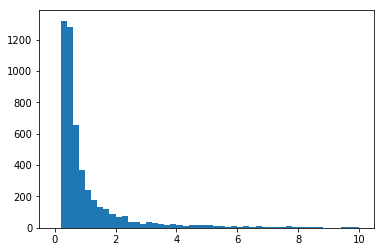

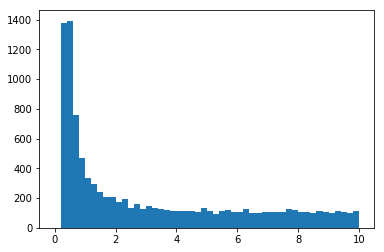

In [3]:
plt.hist(p_mp,50,range=(0.,10.))
plt.show()
p_ges = np.concatenate([p,p_mp])
plt.hist(p_ges,50,range=(0,10))
plt.show()

In [4]:
mass_pi = 0.139
mass_mu = 0.105
mass_e = 0.000511
mass_p = 0.938
mass_K = 0.494
masses = [mass_pi, mass_mu, mass_e, mass_p, mass_K]
masses

[0.139, 0.105, 0.000511, 0.938, 0.494]

In [5]:
signals = []
for mass in masses:
    ITS_tmp = []
    TPCROC0_tmp = []
    TPCROC1_tmp = []
    TPCROC2_tmp = []
    TRD_tmp = []
    TOF_tmp = []
    pmeas_tmp = []
    for p in p_ges:
        bg = p/mass
        beta = bg/math.sqrt(1.+ bg*bg);
        BBS = ROOT.AliExternalTrackParam.BetheBlochSolid(bg)
        BBA = ROOT.AliExternalTrackParam.BetheBlochAleph(bg)
        ITS_tmp.append(np.random.normal(BBS,0.1*BBS) ) ## ITS dEdx = smeared gaus 10% 
        TPCROC0_tmp.append(np.random.normal(BBA,0.1*BBA) )## TPC dEdx = smeared gaus 10% for 1st layer
        TPCROC1_tmp.append(np.random.normal(BBA,0.1*BBA) )  ## TPC dEdx = smeared gaus 10% for 2nd layer
        TPCROC2_tmp.append(np.random.normal(BBA,0.1*BBA) )  ## TPC dEdx = smeared gaus 10% for 3d layer
        TRD_tmp.append(np.random.normal(BBA,0.1*BBA) )  ## TRD dEdx = smeared gaus 10% 
        TOF_tmp.append(np.random.normal(beta,0.1*beta) )  ## TOF - smeared with .... gaussian
        pmeas_tmp.append(np.random.normal(p,0.01*p))
    signals.append({'ITS': ITS_tmp, 'TPCROC0': TPCROC0_tmp, 'TPCROC1': TPCROC1_tmp, 'TPCROC1': TPCROC1_tmp, 
                    'TPCROC2': TPCROC2_tmp, 'TRD': TRD_tmp, 'TOF': TOF_tmp, 'pmeas': pmeas_tmp})

[]

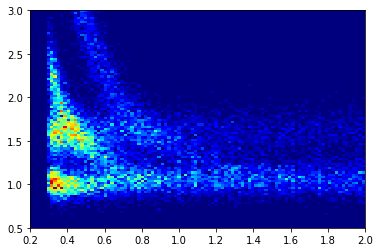

In [6]:
df_list=[]
for i, val in enumerate(masses):
    df = pd.DataFrame.from_dict(signals[i])
    df['p'] = pd.Series(p_ges, index=df.index)
    df['particle'] = pd.Series(i, index=df.index)
    df_list.append(df)
df_all = pd.concat([df_list[0],df_list[2],df_list[3],df_list[4]], ignore_index=True)
plt.hist2d(df_all["p"], df_all["TPCROC1"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.plot()

In [7]:
N=len(df_all)
probabilty = 0.95

flips_raw = (1*(np.random.random(size=6*N)<probabilty)).reshape(6,-1)

flips=flips_raw[0]
for i in range(1,6):
    # (1<<i = 2**i)
    flips=flips_raw[i]*(1<<i) + flips


df_all.loc[:,'flips']=flips
df_all.head(5)

,ITS,TOF,TPCROC0,TPCROC1,TPCROC2,TRD,p,particle,flips
0,0.001974,1.052206,1.287225,1.227018,1.511047,1.352712,6.897096,0,61
1,0.001718,0.833085,0.805002,1.116930,0.872665,0.903301,0.994593,0,63
2,0.001793,0.945460,0.997494,1.009566,1.037719,1.147801,1.728243,0,62
3,0.002160,0.998264,1.462010,1.495788,1.085710,0.951321,6.853458,0,63
4,0.001923,0.921329,1.246285,1.329618,1.318100,1.427665,6.377780,0,63


In [8]:
# prepare "flips-Data" and weights
for i ,name in enumerate(['ITS','TOF','TPCROC0','TPCROC1','TPCROC2','TRD']):
    # calculate "flip= 0/1"
    f=(np.array(df_all['flips'])>>i)&1
    # if f=0 substitute value by mean
    m=df_all[name].mean()
    df_all.loc[:,name+'_mr']= df_all[name].multiply(f,axis='index')+m*(1-f) #mean replaced
    df_all.loc[:,name+'_w']=1.0*f #weight
    df_all.loc[:,name+'_0']= df_all[name].multiply(f,axis='index') #zeros
    
# generate data for stage 2
df_stage_2=df_all.copy()
df_stage_3=df_all.copy()
df_all[df_all['particle']==0].head(10)

,ITS,TOF,TPCROC0,TPCROC1,TPCROC2,TRD,p,particle,flips,ITS_mr,...,TPCROC0_0,TPCROC1_mr,TPCROC1_w,TPCROC1_0,TPCROC2_mr,TPCROC2_w,TPCROC2_0,TRD_mr,TRD_w,TRD_0
0,0.001974,1.052206,1.287225,1.227018,1.511047,1.352712,6.897096,0,61,0.001974,...,1.287225,1.227018,1.0,1.227018,1.511047,1.0,1.511047,1.352712,1.0,1.352712
1,0.001718,0.833085,0.805002,1.116930,0.872665,0.903301,0.994593,0,63,0.001718,...,0.805002,1.116930,1.0,1.116930,0.872665,1.0,0.872665,0.903301,1.0,0.903301
2,0.001793,0.945460,0.997494,1.009566,1.037719,1.147801,1.728243,0,62,0.002535,...,0.997494,1.009566,1.0,1.009566,1.037719,1.0,1.037719,1.147801,1.0,1.147801
3,0.002160,0.998264,1.462010,1.495788,1.085710,0.951321,6.853458,0,63,0.002160,...,1.462010,1.495788,1.0,1.495788,1.085710,1.0,1.085710,0.951321,1.0,0.951321
4,0.001923,0.921329,1.246285,1.329618,1.318100,1.427665,6.377780,0,63,0.001923,...,1.246285,1.329618,1.0,1.329618,1.318100,1.0,1.318100,1.427665,1.0,1.427665
5,0.001694,0.991435,1.127297,1.342507,1.422748,1.317896,5.363184,0,63,0.001694,...,1.127297,1.342507,1.0,1.342507,1.422748,1.0,1.422748,1.317896,1.0,1.317896
6,0.002035,0.962075,1.431967,1.188184,1.180513,1.218372,4.381540,0,63,0.002035,...,1.431967,1.188184,1.0,1.188184,1.180513,1.0,1.180513,1.218372,1.0,1.218372
7,0.002040,0.868408,1.167204,1.238664,1.475020,1.308296,5.465144,0,63,0.002040,...,1.167204,1.238664,1.0,1.238664,1.475020,1.0,1.475020,1.308296,1.0,1.308296
8,0.002084,0.988262,1.112951,1.605666,1.101587,1.206766,5.742133,0,63,0.002084,...,1.112951,1.605666,1.0,1.605666,1.101587,1.0,1.101587,1.206766,1.0,1.206766
9,0.001964,1.069884,1.434137,1.194320,1.131139,1.352150,5.857223,0,61,0.001964,...,1.434137,1.194320,1.0,1.194320,1.131139,1.0,1.131139,1.352150,1.0,1.352150


In [9]:
train, test =train_test_split(df_all, test_size=0.5)

# Create autoencoders

In [10]:
def custom_loss(y_true, y_pred,weights):
    return K.mean(K.square((y_true - y_pred)*weights))

inputs = Input(shape=(6,))
inputw = Input(shape=(6,))
enc1   = Dense(units=64, activation='selu')(inputs)
enc2   = Dense(units=64, activation='selu')(enc1)
enc3   = Dense(units=64, activation='selu')(enc2)
enc4   = Dense(units=64, activation='selu')(enc3)
layer0 = Dense(units=2 , activation='selu')(enc4)
dec1   = Dense(units=64, activation='selu')(layer0)
dec2   = Dense(units=64, activation='selu')(dec1)
dec3   = Dense(units=64, activation='selu')(dec2)
dec4   = Dense(units=64, activation='selu')(dec3)
outputs= Dense(units=6, activation='linear')(dec4)

c_loss = partial(custom_loss, weights=inputw)
        
modelpt = Model(inputs=inputs,outputs=outputs)
models2 = Model(inputs=inputs,outputs=outputs)
modell = Model(inputs=inputs,outputs=outputs)
model0 = Model(inputs=inputs,outputs=outputs)
model1 = Model(inputs=[inputs,inputw],outputs=outputs)
modelpt.compile(loss='mse',
              optimizer='adam',
              metrics=['mse'])
models2.compile(loss='mse',
              optimizer='adam',
              metrics=['mse'])
modell.compile(loss='mse',
              optimizer='adam',
              metrics=['mse'])
model0.compile(loss='mse',
              optimizer='adam',
              metrics=['mse'])
model1.compile(loss=c_loss,
              optimizer='adam',
              metrics=['mse'])

In [11]:
model0.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 6)                 0         
_________________________________________________________________
dense (Dense)                (None, 64)                448       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 130       
_________________________________________________________________
dense_5 (Dense)              (None, 64)                192       
__________

# perfect tracks

In [12]:
train_pt = train[["ITS", "TOF", "TPCROC0", "TPCROC1", "TPCROC2", "TRD"]]
test_pt = test[["ITS", "TOF", "TPCROC0", "TPCROC1", "TPCROC2", "TRD"]]
scaler_pt = StandardScaler()
scaler_pt.fit( train[["ITS", "TOF", "TPCROC0", "TPCROC1", "TPCROC2", "TRD"]])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [13]:
modelpt.fit(scaler_pt.transform(train_pt), scaler_pt.transform(train_pt), epochs=5, batch_size=32, 
          validation_data=[scaler_pt.transform(test_pt),scaler_pt.transform(test_pt)])

Train on 20000 samples, validate on 20000 samples
Epoch 1/5
20000/20000 [==============================] - 6s 309us/step - loss: 0.0631 - mean_squared_error: 0.0631 - val_loss: 0.0485 - val_mean_squared_error: 0.0485
Epoch 2/5
20000/20000 [==============================] - 5s 250us/step - loss: 0.0389 - mean_squared_error: 0.0389 - val_loss: 0.0366 - val_mean_squared_error: 0.0366
Epoch 3/5
20000/20000 [==============================] - 5s 251us/step - loss: 0.0416 - mean_squared_error: 0.0416 - val_loss: 0.0376 - val_mean_squared_error: 0.0376
Epoch 4/5
20000/20000 [==============================] - 5s 252us/step - loss: 0.0354 - mean_squared_error: 0.0354 - val_loss: 0.0340 - val_mean_squared_error: 0.0340
Epoch 5/5
20000/20000 [==============================] - 5s 251us/step - loss: 0.0359 - mean_squared_error: 0.0359 - val_loss: 0.0341 - val_mean_squared_error: 0.0341


2019-01-28 12:40:43.482620: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: FMA


In [14]:
out = scaler_pt.inverse_transform(modelpt.predict(scaler_pt.transform(test_pt)))
AE_predict = pd.DataFrame(out)
AE_predict.columns = ["ITS_ae", "TOF_ae", "TPCROC0_ae", "TPCROC1_ae", "TPCROC2_ae", "TRD_ae"]
test = test.reset_index()
df_test = pd.concat([test,AE_predict], axis = 1)
df_test.head(3)

,index,ITS,TOF,TPCROC0,TPCROC1,TPCROC2,TRD,p,particle,flips,...,TPCROC2_0,TRD_mr,TRD_w,TRD_0,ITS_ae,TOF_ae,TPCROC0_ae,TPCROC1_ae,TPCROC2_ae,TRD_ae
0,7811,0.001794,0.948008,1.041207,1.042903,1.138377,0.938865,0.334052,0,63,...,1.138377,0.938865,1.0,0.938865,0.001758,0.950034,1.025298,1.030729,1.031214,1.075571
1,12703,0.002671,0.909689,1.705175,1.629766,1.537096,1.597416,3.395587,2,63,...,1.537096,1.597416,1.0,1.597416,0.002754,0.915538,1.558491,1.545281,1.580396,1.596055
2,38477,0.002263,0.797245,1.589065,1.572257,1.281461,1.413690,0.541052,4,61,...,1.281461,1.413690,1.0,1.413690,0.002489,0.791904,1.438869,1.389904,1.439425,1.469368


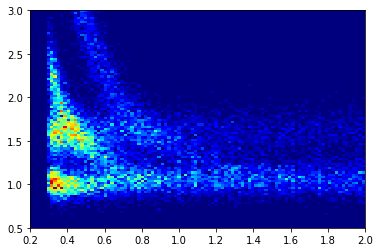

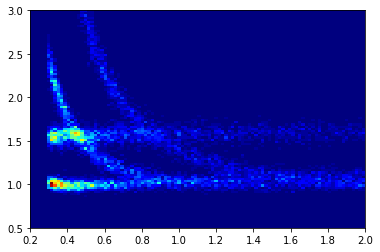

In [15]:
plt.hist2d(df_all["p"], df_all["TPCROC1"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()
plt.hist2d(df_test["p"], df_test["TPCROC2_ae"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()

# Train with zeros

In [16]:
train_0 = train[["ITS_0", "TOF_0", "TPCROC0_0", "TPCROC1_0", "TPCROC2_0", "TRD_0"]]
test_0 = test[["ITS_0", "TOF_0", "TPCROC0_0", "TPCROC1_0", "TPCROC2_0", "TRD_0"]]
scaler_0 = StandardScaler()
scaler_0.fit( train[["ITS_0", "TOF_0", "TPCROC0_0", "TPCROC1_0", "TPCROC2_0", "TRD_0"]])
#scaler_0.fit( train[["ITS", "TOF", "TPCROC0", "TPCROC1", "TPCROC2", "TRD"]]) 

StandardScaler(copy=True, with_mean=True, with_std=True)

In [17]:
train[["ITS_0", "TOF_0", "TPCROC0_0", "TPCROC1_0", "TPCROC2_0", "TRD_0"]].head()

,ITS_0,TOF_0,TPCROC0_0,TPCROC1_0,TPCROC2_0,TRD_0
13698,0.002673,0.954562,1.254264,1.688195,1.431549,0.000000
3896,0.001773,1.048043,1.303439,1.219996,1.066433,1.226713
24109,0.001852,0.906697,1.078619,1.155178,1.334854,0.932480
22534,0.001571,0.974656,0.936389,1.174052,1.016284,1.007817
36826,0.001951,0.863774,1.141814,0.993991,1.018198,1.141116


In [18]:
train[["ITS", "TOF", "TPCROC0", "TPCROC1", "TPCROC2", "TRD"]].head()


,ITS,TOF,TPCROC0,TPCROC1,TPCROC2,TRD
13698,0.002673,0.954562,1.254264,1.688195,1.431549,1.701219
3896,0.001773,1.048043,1.303439,1.219996,1.066433,1.226713
24109,0.001852,0.906697,1.078619,1.155178,1.334854,0.932480
22534,0.001571,0.974656,0.936389,1.174052,1.016284,1.007817
36826,0.001951,0.863774,1.141814,0.993991,1.018198,1.141116


In [19]:
model0.fit(scaler_0.transform(train_0), scaler_0.transform(train_0), epochs=5, batch_size=32, 
          validation_data=[scaler_0.transform(test_0),scaler_0.transform(test_0)])

Train on 20000 samples, validate on 20000 samples
Epoch 1/5
20000/20000 [==============================] - 6s 316us/step - loss: 0.1711 - mean_squared_error: 0.1711 - val_loss: 0.1631 - val_mean_squared_error: 0.1631
Epoch 2/5
20000/20000 [==============================] - 5s 254us/step - loss: 0.1683 - mean_squared_error: 0.1683 - val_loss: 0.1694 - val_mean_squared_error: 0.1694
Epoch 3/5
20000/20000 [==============================] - 5s 257us/step - loss: 0.1628 - mean_squared_error: 0.1628 - val_loss: 0.1534 - val_mean_squared_error: 0.1534
Epoch 4/5
20000/20000 [==============================] - 5s 262us/step - loss: 0.1620 - mean_squared_error: 0.1620 - val_loss: 0.1488 - val_mean_squared_error: 0.1488
Epoch 5/5
20000/20000 [==============================] - 5s 258us/step - loss: 0.1510 - mean_squared_error: 0.1510 - val_loss: 0.1515 - val_mean_squared_error: 0.1515


In [20]:
out = scaler_0.inverse_transform(model0.predict(scaler_0.transform(test_0)))
AE_predict = pd.DataFrame(out)
AE_predict.columns = ["ITS_ae", "TOF_ae", "TPCROC0_ae", "TPCROC1_ae", "TPCROC2_ae", "TRD_ae"]
test = test.reset_index()
df_test = pd.concat([test,AE_predict], axis = 1)
df_test.head(3)

,level_0,index,ITS,TOF,TPCROC0,TPCROC1,TPCROC2,TRD,p,particle,...,TPCROC2_0,TRD_mr,TRD_w,TRD_0,ITS_ae,TOF_ae,TPCROC0_ae,TPCROC1_ae,TPCROC2_ae,TRD_ae
0,0,7811,0.001794,0.948008,1.041207,1.042903,1.138377,0.938865,0.334052,0,...,1.138377,0.938865,1.0,0.938865,0.001634,0.965003,1.008330,1.075787,0.956334,1.010984
1,1,12703,0.002671,0.909689,1.705175,1.629766,1.537096,1.597416,3.395587,2,...,1.537096,1.597416,1.0,1.597416,0.002683,0.858002,1.663404,1.691147,1.681357,1.674180
2,2,38477,0.002263,0.797245,1.589065,1.572257,1.281461,1.413690,0.541052,4,...,1.281461,1.413690,1.0,1.413690,0.002207,0.015447,1.152994,1.259093,1.226793,1.285596


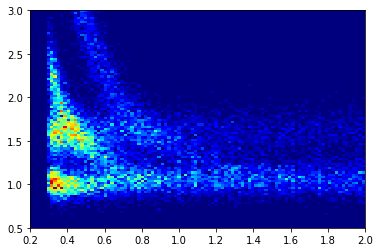

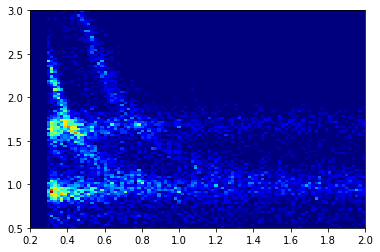

In [21]:
plt.hist2d(df_all["p"], df_all["TPCROC1"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()
plt.hist2d(df_test["p"], df_test["TPCROC2_ae"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()

# labels for missing tracks

In [22]:
train_in = train[["ITS_mr", "TOF_mr", "TPCROC0_mr", "TPCROC1_mr", "TPCROC2_mr", "TRD_mr"]]
train_out = train[["ITS", "TOF", "TPCROC0", "TPCROC1", "TPCROC2", "TRD"]]
test_in = test[["ITS_mr", "TOF_mr", "TPCROC0_mr", "TPCROC1_mr", "TPCROC2_mr", "TRD_mr"]]
test_out = test[["ITS", "TOF", "TPCROC0", "TPCROC1", "TPCROC2", "TRD"]]
scaler_in = StandardScaler()
scaler_out = StandardScaler()
scaler_in.fit(train_in)
scaler_out.fit(train_out)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [23]:
modell.fit(scaler_in.transform(train_in), scaler_out.transform(train_out), epochs=5, batch_size=32, 
          validation_data=[scaler_in.transform(test_in),scaler_out.transform(test_out)])

Train on 20000 samples, validate on 20000 samples
Epoch 1/5
20000/20000 [==============================] - 7s 334us/step - loss: 0.0491 - mean_squared_error: 0.0491 - val_loss: 0.0431 - val_mean_squared_error: 0.0431
Epoch 2/5
20000/20000 [==============================] - 5s 256us/step - loss: 0.0457 - mean_squared_error: 0.0457 - val_loss: 0.0621 - val_mean_squared_error: 0.0621
Epoch 3/5
20000/20000 [==============================] - 5s 264us/step - loss: 0.0441 - mean_squared_error: 0.0441 - val_loss: 0.0458 - val_mean_squared_error: 0.0458
Epoch 4/5
20000/20000 [==============================] - 5s 255us/step - loss: 0.0434 - mean_squared_error: 0.0434 - val_loss: 0.0431 - val_mean_squared_error: 0.0431
Epoch 5/5
20000/20000 [==============================] - 5s 250us/step - loss: 0.0440 - mean_squared_error: 0.0440 - val_loss: 0.0408 - val_mean_squared_error: 0.0408


In [24]:
out = scaler_out.inverse_transform(modell.predict(scaler_in.transform(test_in)))
AE_predict = pd.DataFrame(out)
AE_predict.columns = ["ITS_ae", "TOF_ae", "TPCROC0_ae", "TPCROC1_ae", "TPCROC2_ae", "TRD_ae"]
#test = test.reset_index()
df_test = pd.concat([test,AE_predict], axis = 1)
df_test.head(3)

,level_0,index,ITS,TOF,TPCROC0,TPCROC1,TPCROC2,TRD,p,particle,...,TPCROC2_0,TRD_mr,TRD_w,TRD_0,ITS_ae,TOF_ae,TPCROC0_ae,TPCROC1_ae,TPCROC2_ae,TRD_ae
0,0,7811,0.001794,0.948008,1.041207,1.042903,1.138377,0.938865,0.334052,0,...,1.138377,0.938865,1.0,0.938865,0.001763,0.960735,1.051654,1.028544,1.043299,1.030806
1,1,12703,0.002671,0.909689,1.705175,1.629766,1.537096,1.597416,3.395587,2,...,1.537096,1.597416,1.0,1.597416,0.002768,0.944207,1.619306,1.599866,1.617521,1.601192
2,2,38477,0.002263,0.797245,1.589065,1.572257,1.281461,1.413690,0.541052,4,...,1.281461,1.413690,1.0,1.413690,0.002395,0.943591,1.453990,1.427630,1.446205,1.428187


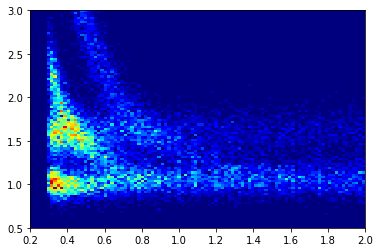

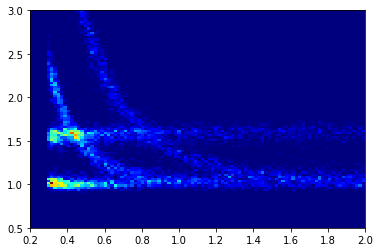

In [25]:
plt.hist2d(df_all["p"], df_all["TPCROC1"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()
plt.hist2d(df_test["p"], df_test["TPCROC1_ae"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()

# mean input, zero weights for missing values

In [26]:
train_mr = train[["ITS_mr", "TOF_mr", "TPCROC0_mr", "TPCROC1_mr", "TPCROC2_mr", "TRD_mr"]]
test_mr = test[["ITS_mr", "TOF_mr", "TPCROC0_mr", "TPCROC1_mr", "TPCROC2_mr", "TRD_mr"]]
train_w    = train[["ITS_w", "TOF_w", "TPCROC0_w", "TPCROC1_w", "TPCROC2_w", "TRD_w"]]
test_w     = test[["ITS_w", "TOF_w", "TPCROC0_w", "TPCROC1_w", "TPCROC2_w", "TRD_w"]]

In [27]:
scaler_mr = StandardScaler()
scaler_mr.fit(train_mr)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [28]:
model1.fit([scaler_mr.transform(train_mr),train_w], scaler_mr.transform(train_mr), epochs=5, batch_size=32, 
          validation_data=[[scaler_mr.transform(test_mr),train_w],scaler_mr.transform(test_mr)])

Train on 20000 samples, validate on 20000 samples
Epoch 1/5
20000/20000 [==============================] - 7s 333us/step - loss: 0.0364 - mean_squared_error: 0.0787 - val_loss: 0.0749 - val_mean_squared_error: 0.0789
Epoch 2/5
20000/20000 [==============================] - 5s 259us/step - loss: 0.0347 - mean_squared_error: 0.0766 - val_loss: 0.0738 - val_mean_squared_error: 0.0777
Epoch 3/5
20000/20000 [==============================] - 5s 259us/step - loss: 0.0350 - mean_squared_error: 0.0760 - val_loss: 0.0749 - val_mean_squared_error: 0.0789
Epoch 4/5
20000/20000 [==============================] - 5s 258us/step - loss: 0.0337 - mean_squared_error: 0.0759 - val_loss: 0.0720 - val_mean_squared_error: 0.0760
Epoch 5/5
20000/20000 [==============================] - 5s 267us/step - loss: 0.0332 - mean_squared_error: 0.0755 - val_loss: 0.0709 - val_mean_squared_error: 0.0747


In [29]:
out = scaler_mr.inverse_transform(model1.predict([scaler_mr.transform(test_mr),test_w]))
AE_predict = pd.DataFrame(out)
AE_predict.columns = ["ITS_ae", "TOF_ae", "TPCROC0_ae", "TPCROC1_ae", "TPCROC2_ae", "TRD_ae"]
#test = test.reset_index()
df_test = pd.concat([test,AE_predict], axis = 1)
df_test.head(3)

,level_0,index,ITS,TOF,TPCROC0,TPCROC1,TPCROC2,TRD,p,particle,...,TPCROC2_0,TRD_mr,TRD_w,TRD_0,ITS_ae,TOF_ae,TPCROC0_ae,TPCROC1_ae,TPCROC2_ae,TRD_ae
0,0,7811,0.001794,0.948008,1.041207,1.042903,1.138377,0.938865,0.334052,0,...,1.138377,0.938865,1.0,0.938865,0.001664,0.946046,1.053349,1.049958,1.047745,1.035317
1,1,12703,0.002671,0.909689,1.705175,1.629766,1.537096,1.597416,3.395587,2,...,1.537096,1.597416,1.0,1.597416,0.002739,0.916400,1.615204,1.609016,1.608764,1.611905
2,2,38477,0.002263,0.797245,1.589065,1.572257,1.281461,1.413690,0.541052,4,...,1.281461,1.413690,1.0,1.413690,0.002353,0.913534,1.448515,1.442156,1.439780,1.440622


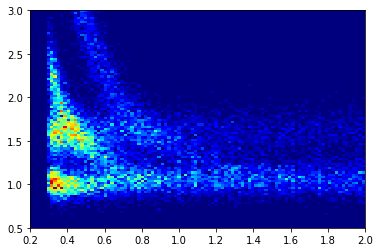

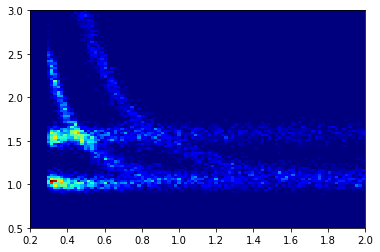

In [30]:
plt.hist2d(df_all["p"], df_all["TPCROC1"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()
plt.hist2d(df_test["p"], df_test["TPCROC1_ae"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()

# second iteration, replace missing values by values from first iteration

In [31]:
# stage 2
stage2_data = df_stage_2[["ITS_mr", "TOF_mr", "TPCROC0_mr", "TPCROC1_mr", "TPCROC2_mr", "TRD_mr"]]
out = scaler_mr.inverse_transform(models2.predict(scaler_mr.transform(stage2_data)))
AE_predict = pd.DataFrame(out)
AE_predict.columns = ["ITS_ae", "TOF_ae", "TPCROC0_ae", "TPCROC1_ae", "TPCROC2_ae", "TRD_ae"]
for i ,name in enumerate(['ITS','TOF','TPCROC0','TPCROC1','TPCROC2','TRD']):
    # calculate "flip= 0/1"
    f=(np.array(df_stage_2['flips'])>>i)&1
    m=AE_predict[name+'_ae']
    df_stage_2.loc[:,name+'_s2']= df_stage_2[name].multiply(f,axis='index')+m*(1-f)

In [32]:
train, test =train_test_split(df_stage_2, test_size=0.5)
train_s2 = train[["ITS_s2", "TOF_s2", "TPCROC0_s2", "TPCROC1_s2", "TPCROC2_s2", "TRD_s2"]]
test_s2 = test[["ITS_s2", "TOF_s2", "TPCROC0_s2", "TPCROC1_s2", "TPCROC2_s2", "TRD_s2"]]

In [33]:
scaler_s2 = StandardScaler()
scaler_s2.fit(train_s2)
models2.fit(scaler_s2.transform(train_s2), scaler_s2.transform(train_s2), epochs=5, batch_size=32, 
          validation_data=[scaler_s2.transform(test_s2),scaler_s2.transform(test_s2)])

Train on 20000 samples, validate on 20000 samples
Epoch 1/5
20000/20000 [==============================] - 7s 362us/step - loss: 0.0304 - mean_squared_error: 0.0304 - val_loss: 0.0291 - val_mean_squared_error: 0.0291
Epoch 2/5
20000/20000 [==============================] - 5s 268us/step - loss: 0.0298 - mean_squared_error: 0.0298 - val_loss: 0.0307 - val_mean_squared_error: 0.0307
Epoch 3/5
20000/20000 [==============================] - 5s 267us/step - loss: 0.0292 - mean_squared_error: 0.0292 - val_loss: 0.0303 - val_mean_squared_error: 0.0303
Epoch 4/5
20000/20000 [==============================] - 5s 266us/step - loss: 0.0302 - mean_squared_error: 0.0302 - val_loss: 0.0285 - val_mean_squared_error: 0.0285
Epoch 5/5
20000/20000 [==============================] - 5s 265us/step - loss: 0.0292 - mean_squared_error: 0.0292 - val_loss: 0.0299 - val_mean_squared_error: 0.0299


In [34]:
out = scaler_s2.inverse_transform(models2.predict(scaler_s2.transform(test_s2)))
AE_predict = pd.DataFrame(out)
AE_predict.columns = ["ITS_ae", "TOF_ae", "TPCROC0_ae", "TPCROC1_ae", "TPCROC2_ae", "TRD_ae"]
test = test.reset_index()
df_test = pd.concat([test,AE_predict], axis = 1)
df_test.head(3)

,index,ITS,TOF,TPCROC0,TPCROC1,TPCROC2,TRD,p,particle,flips,...,TPCROC0_s2,TPCROC1_s2,TPCROC2_s2,TRD_s2,ITS_ae,TOF_ae,TPCROC0_ae,TPCROC1_ae,TPCROC2_ae,TRD_ae
0,10322,0.002704,0.732140,1.508346,1.742123,1.594049,1.688792,4.394304,2,31,...,1.508346,1.742123,1.594049,1.597327,0.002645,0.733805,1.574466,1.536682,1.548998,1.538450
1,17780,0.002604,1.046529,1.562858,1.650241,1.442308,1.568808,0.370109,2,63,...,1.562858,1.650241,1.442308,1.568808,0.002613,1.041425,1.561822,1.539439,1.558715,1.557867
2,29238,0.005684,0.533311,2.656244,2.986480,2.758478,2.723266,0.538645,3,31,...,2.656244,2.986480,2.758478,2.723583,0.005308,0.536527,2.770090,2.674274,2.827383,2.730608


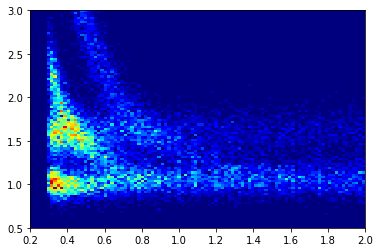

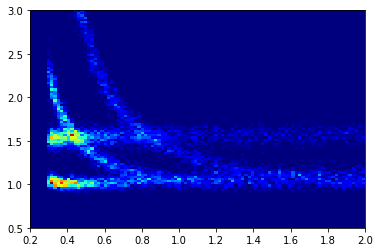

In [35]:
plt.hist2d(df_all["p"], df_all["TPCROC1"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()
plt.hist2d(df_test["p"], df_test["TPCROC1_ae"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()